In [3]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.inspection import permutation_importance

In [4]:
df = pd.read_csv('../../data/preprocessed/realestates_kh_SelectKBest_v2.csv')  

In [5]:
X = df.drop(['price'], axis=1)
y = df['price']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
)

In [7]:
print("Max value in X_train:", X_train.max().max())
print("Max value in X_test:", X_test.max().max())
print("Max value in y_train:", y_train.max())
print("Max value in y_test:", y_test.max())


Max value in X_train: 104635
Max value in X_test: 55811
Max value in y_train: 188343000.0
Max value in y_test: 276264450.0


In [8]:
linear_model = LinearRegression()

In [9]:
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=63,
    learning_rate=0.05,
    n_estimators=1000,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1  # Silence LightGBM output
)

In [10]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=800,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [11]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

In [12]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np

# Define parameter grids for each model type
param_grids = {
    "Linear Regression": {
        'fit_intercept': [True, False],
        'positive': [True, False]  # For constrained regression
    },
    "LightGBM": {
        'num_leaves': [15, 31, 63],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [500, 1000, 1500],
        'min_child_samples': [5, 20, 50],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [0, 0.1, 1]
    },
    "XGBoost": {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [500, 1000, 1500],
        'gamma': [0, 0.1, 0.5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    "Random Forest": {
        'n_estimators': [300, 500, 800],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 0.8, None]
    }
}

In [13]:
tuning_method = {
    "Linear Regression": GridSearchCV,
    "LightGBM": RandomizedSearchCV,
    "XGBoost": RandomizedSearchCV,
    "Random Forest": RandomizedSearchCV
}
search_params = {
    'cv': 5,
    'scoring': 'r2',
    'n_jobs': -1,
    'verbose': 1
}

randomized_settings = {
    'n_iter': 20  # Number of parameter settings sampled
}

In [14]:
models = {
    "Linear Regression": linear_model,
    "LightGBM": lgb_model,
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
}

In [15]:
from sklearn.preprocessing import StandardScaler

# 1. Scale the target variable (y)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.to_numpy().reshape(-1, 1)).flatten()

In [16]:
import time
tuned_models = {}
best_params = {}

for name, model in models.items():
    print(f"\n{'='*40}\nTuning {name}\n{'='*40}")
    
    start_time = time.time()
    
    # Initialize search object
    if tuning_method[name] == RandomizedSearchCV:
        search = RandomizedSearchCV(
            model,
            param_grids[name],
            **search_params,
            **randomized_settings,
            random_state=42
        )
    else:
        search = GridSearchCV(
            model,
            param_grids[name],
            **search_params
        )
    
    search.fit(X_train, y_train_scaled)
    
    # Store results
    tuned_models[name] = search.best_estimator_
    best_params[name] = search.best_params_
    
    print(f"Tuning completed in {time.time()-start_time:.1f}s")
    print(f"Best R²: {search.best_score_:.4f}")
    print(f"Best params: {search.best_params_}")


Tuning Linear Regression
Fitting 5 folds for each of 4 candidates, totalling 20 fits


Tuning completed in 23.4s
Best R²: -0.0469
Best params: {'fit_intercept': False, 'positive': True}

Tuning LightGBM
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 152.4s
Best R²: 0.4629
Best params: {'reg_lambda': 0, 'reg_alpha': 1, 'num_leaves': 15, 'n_estimators': 1000, 'min_child_samples': 5, 'learning_rate': 0.01}

Tuning XGBoost
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 60.0s
Best R²: 0.6905
Best params: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}

Tuning Random Forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 216.7s
Best R²: 0.7204
Best params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Initialize 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}
for name, model in tuned_models.items():
    print(f"\n{'='*40}\nCross-validating {name}\n{'='*40}")
    
    # Perform cross-validation
    scores = cross_val_score(
        model,
        X_train,
        y_train_scaled,
        cv=kf,
        scoring='r2',
        n_jobs=-1
    )
    
    # Store results
    cv_results[name] = {
        'mean_r2': np.mean(scores),
        'std_r2': np.std(scores),
        'all_scores': scores
    }
    
    print(f"Mean R²: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    print(f"All fold scores: {scores}")


Cross-validating Linear Regression
Mean R²: 0.2918 ± 0.2033
All fold scores: [0.12421371 0.01587892 0.28251566 0.51864562 0.51752659]

Cross-validating LightGBM
Mean R²: 0.4503 ± 0.1916
All fold scores: [0.20858458 0.33121842 0.56378113 0.75768064 0.39023752]

Cross-validating XGBoost
Mean R²: 0.7754 ± 0.1514
All fold scores: [0.89172973 0.81328154 0.86458567 0.82961231 0.47755377]

Cross-validating Random Forest
Mean R²: 0.7695 ± 0.2042
All fold scores: [0.85578593 0.82814407 0.94446047 0.8505056  0.36884186]


In [18]:
from sklearn.model_selection import cross_validate

scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error'
}

detailed_cv = {}
for name, model in tuned_models.items():
    print(f"\nEvaluating {name} with multiple metrics...")
    
    results = cross_validate(
        model,
        X_train,
        y_train_scaled,
        cv=kf,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    
    detailed_cv[name] = {
        'test_r2': results['test_r2'],
        'test_mae': -results['test_mae'],
        'test_mse': -results['test_mse'],
        'train_r2': results['train_r2']
    }
    
    print(f"Test R²: {np.mean(results['test_r2']):.4f} ± {np.std(results['test_r2']):.4f}")
    print(f"Test MAE: {np.mean(-results['test_mae']):.4f} ± {np.std(-results['test_mae']):.4f}")


Evaluating Linear Regression with multiple metrics...
Test R²: 0.2918 ± 0.2033
Test MAE: 0.2418 ± 0.0087

Evaluating LightGBM with multiple metrics...
Test R²: 0.4503 ± 0.1916
Test MAE: 0.0705 ± 0.0100

Evaluating XGBoost with multiple metrics...
Test R²: 0.7754 ± 0.1514
Test MAE: 0.0578 ± 0.0174

Evaluating Random Forest with multiple metrics...
Test R²: 0.7695 ± 0.2042
Test MAE: 0.0376 ± 0.0213


In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score

# Create price tiers for stratification
price_tiers = pd.qcut(y_train, q=5, labels=False)

strat_cv_results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in tuned_models.items():
    scores = []
    for train_idx, val_idx in skf.split(X_train, price_tiers):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train_scaled[train_idx], y_train_scaled[val_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        scores.append(r2_score(y_val, preds))
    strat_cv_results[name] = scores
    print(f"{name} Stratified CV R²: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

Linear Regression Stratified CV R²: -0.2704 ± 1.1425
LightGBM Stratified CV R²: 0.4490 ± 0.3092
XGBoost Stratified CV R²: 0.7446 ± 0.1952
Random Forest Stratified CV R²: 0.7395 ± 0.2228


In [20]:
# Compare all CV results
final_model_name = max(cv_results, key=lambda x: cv_results[x]['mean_r2'])
final_model = tuned_models[final_model_name]

print(f"\n{'='*40}")
print(f"Best Model: {final_model_name}")
print(f"Mean CV R²: {cv_results[final_model_name]['mean_r2']:.4f}")
print(f"Best Parameters: {best_params[final_model_name]}")
print('='*40)

# Evaluate on test set
test_pred = final_model.predict(X_test)
test_r2 = r2_score(y_test_scaled, test_pred)
print(f"Test Set R²: {test_r2:.4f}")


Best Model: XGBoost
Mean CV R²: 0.7754
Best Parameters: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}
Test Set R²: 0.2137


In [21]:
final_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [22]:
# 1. Predict on test set using your final model
test_pred_scaled = final_model.predict(X_test)

# Inverse transform scaled predictions to original price scale
test_pred = y_scaler.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()
y_test_actual = y_test.values  # Already in original scale

# Calculate residuals
residuals = y_test_actual - test_pred

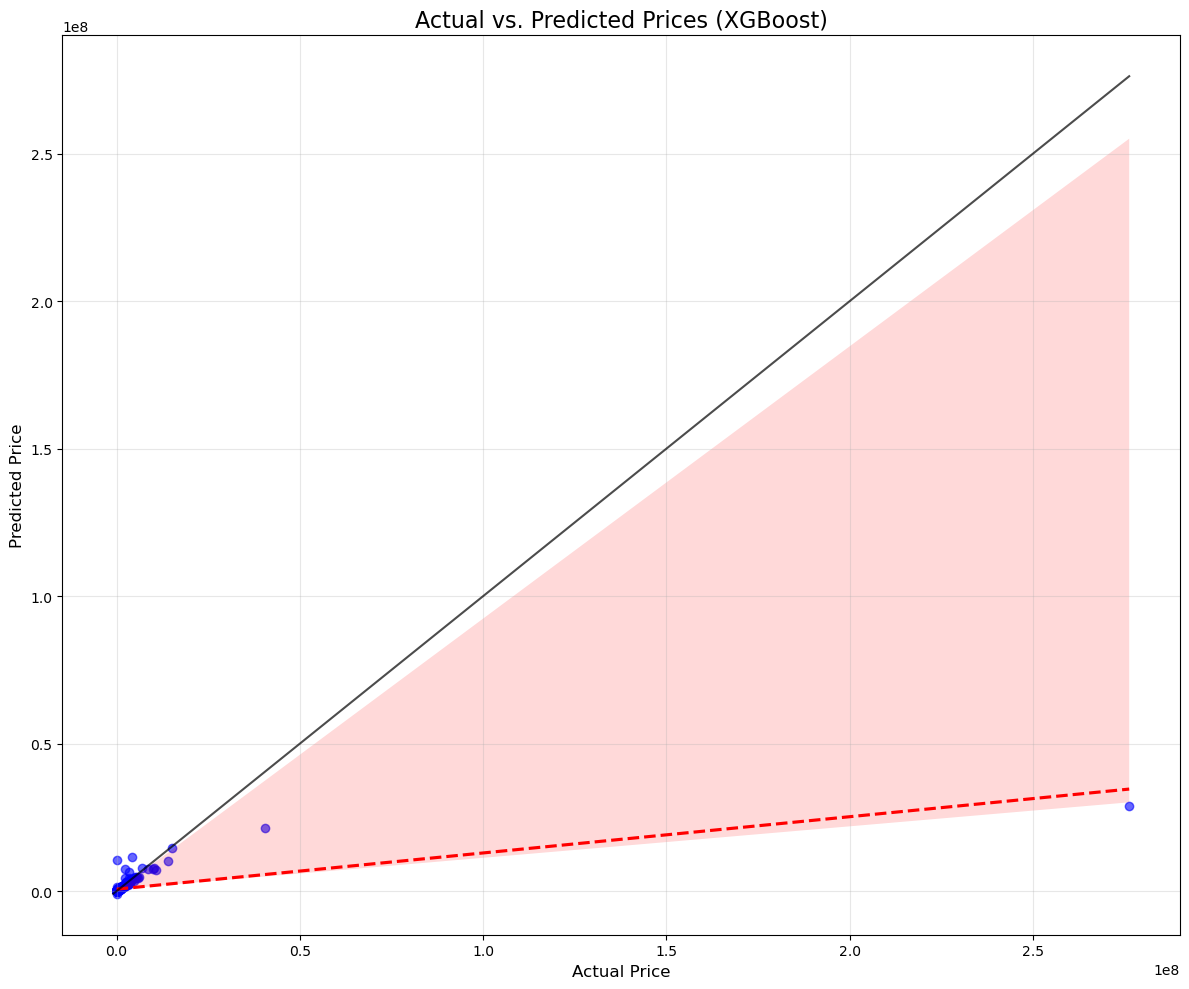

In [23]:
# 2. Create Actual vs. Predicted scatter plot
plt.figure(figsize=(12, 10))

# Scatter plot with regression line
sns.regplot(
    x=y_test_actual, 
    y=test_pred,
    scatter_kws={'alpha': 0.6, 'color': 'blue'},
    line_kws={'color': 'red', 'linestyle': '--'}
)

# Perfect prediction line
max_val = max(y_test_actual.max(), test_pred.max())
min_val = min(y_test_actual.min(), test_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], 'k-', alpha=0.7)

plt.title(f'Actual vs. Predicted Prices ({final_model_name})', fontsize=16)
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


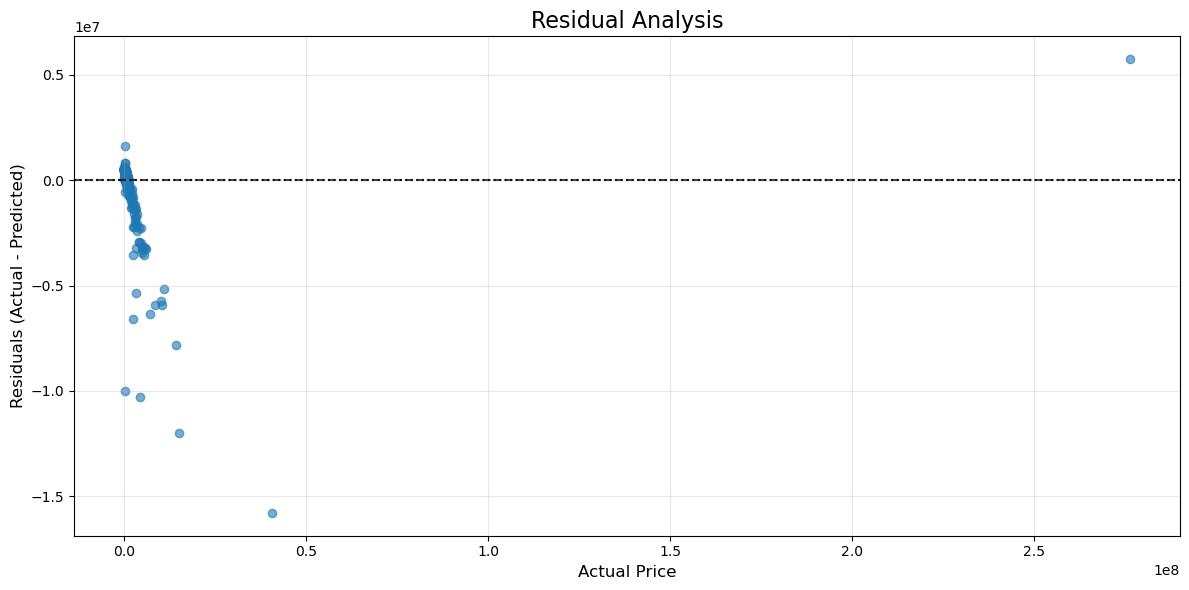

In [27]:
# 3. Residual plot
plt.figure(figsize=(12, 6))
sns.residplot(
    x=y_test_actual, 
    y=residuals,
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red', 'lw': 2}
)
plt.title('Residual Analysis', fontsize=16)
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.7)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

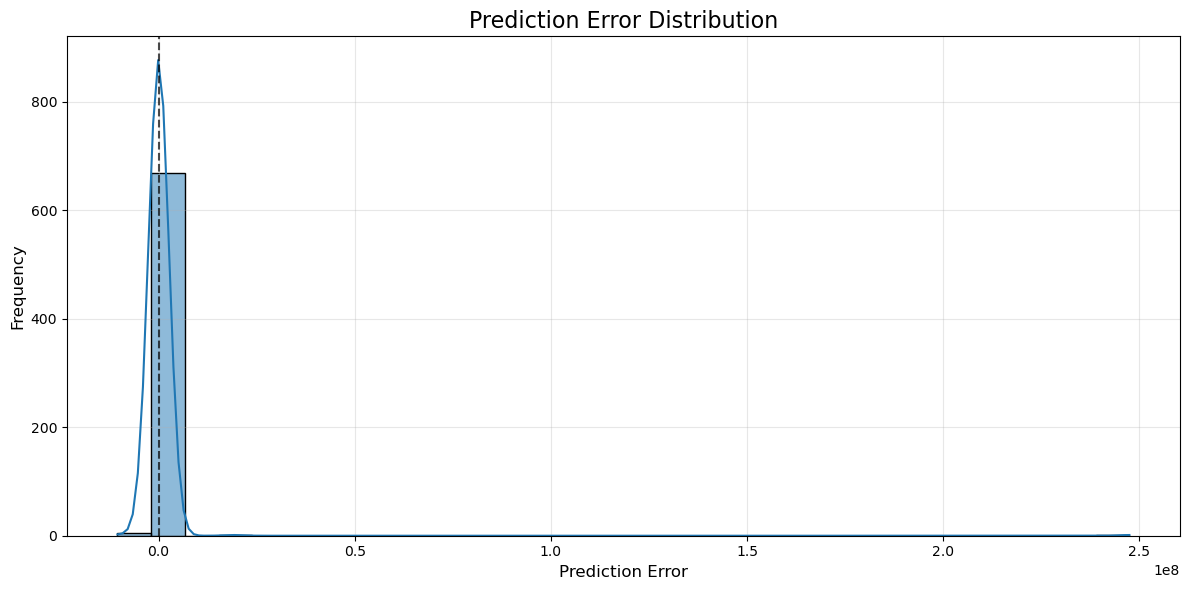

In [25]:
# 4. Error distribution plot
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Prediction Error Distribution', fontsize=16)
plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.7)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

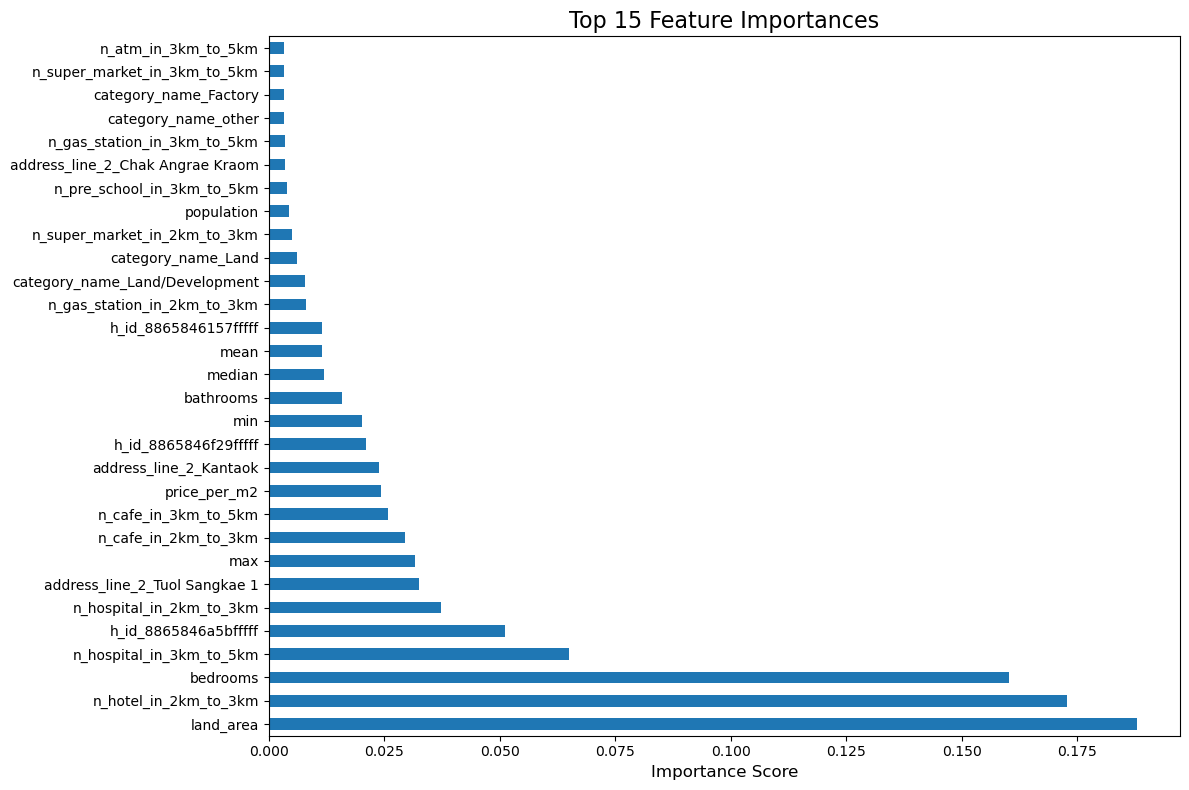

In [28]:
# 5. Feature Importance (for tree-based models)
if hasattr(final_model, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    feat_importances = pd.Series(
        final_model.feature_importances_, 
        index=X_train.columns
    ).sort_values(ascending=False)
    
    feat_importances[:30].plot(kind='barh')  # Top 15 features
    plt.title('Top 15 Feature Importances', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.tight_layout()
    plt.show()

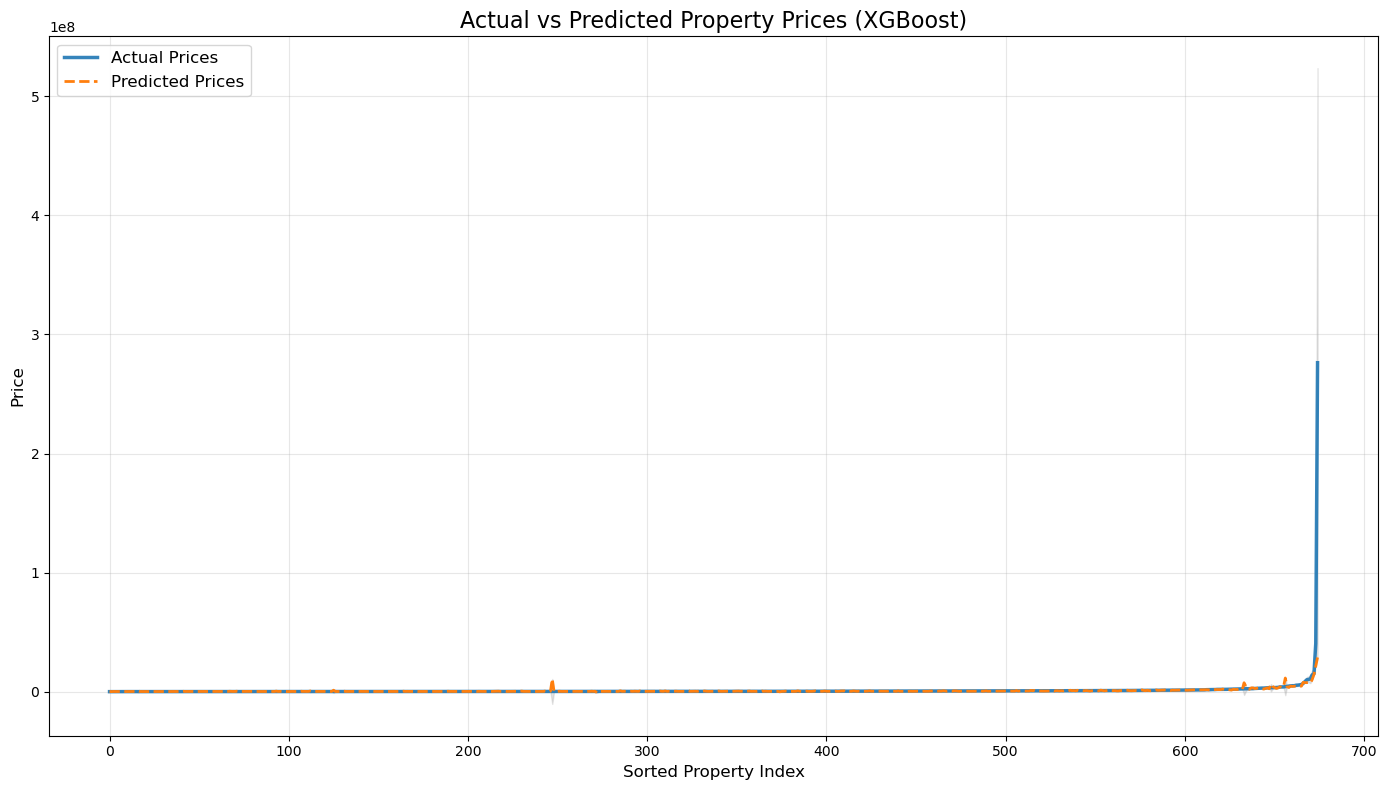

Model Performance Metrics:
R²: 0.2137
MAE: 575756.0569
Average Price: 1134220.9659
MAE as % of Average: 50.76%


In [29]:
# Predict on test set
test_pred_scaled = final_model.predict(X_test)
test_pred = y_scaler.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

# Create sorted comparison DataFrame
results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': test_pred
}).sort_values(by='Actual').reset_index(drop=True)

# Create line chart
plt.figure(figsize=(14, 8))
plt.plot(results.index, results['Actual'], label='Actual Prices', 
         color='#1f77b4', linewidth=2.5, alpha=0.9)
plt.plot(results.index, results['Predicted'], label='Predicted Prices', 
         color='#ff7f0e', linestyle='--', linewidth=2)

# Add labels and title
plt.title(f'Actual vs Predicted Property Prices ({final_model_name})', fontsize=16)
plt.xlabel('Sorted Property Index', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Add error band visualization
plt.fill_between(
    results.index,
    results['Actual'] - (results['Actual'] - results['Predicted']),
    results['Actual'] + (results['Actual'] - results['Predicted']),
    color='gray',
    alpha=0.2,
    label='Error Range'
)

plt.tight_layout()
plt.show()

# Add performance metrics to the plot
mae = mean_absolute_error(results['Actual'], results['Predicted'])
r2 = r2_score(results['Actual'], results['Predicted'])

print(f"Model Performance Metrics:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Average Price: {results['Actual'].mean():.4f}")
print(f"MAE as % of Average: {(mae/results['Actual'].mean())*100:.2f}%")

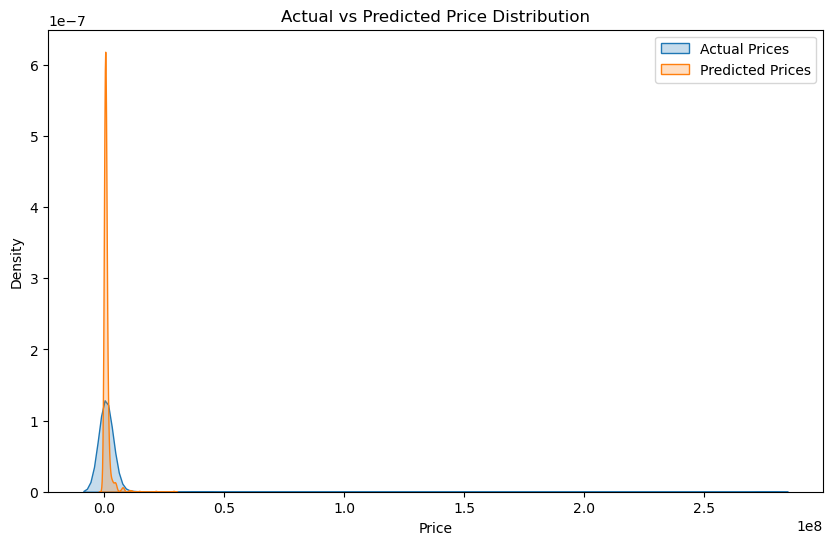

In [30]:
# Check prediction distribution vs actual
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test_actual, label='Actual Prices', fill=True)
sns.kdeplot(test_pred, label='Predicted Prices', fill=True)
plt.title('Actual vs Predicted Price Distribution')
plt.xlabel('Price')
plt.legend()
plt.show()

In [32]:
# 1. Import necessary libraries
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# 2. Prepare base models (use your tuned models)
base_models = [
    ('xgb', tuned_models['XGBoost']),
    ('rf', tuned_models['Random Forest']),
    ('lgb', tuned_models['LightGBM'])
]

# 3. Choose meta-learner (Ridge regression works well)
meta_learner = Ridge(alpha=1.0)

# 4. Create stacking model
stack_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,  # Use same folds as your CV
    n_jobs=-1,
    passthrough=True  # Include original features with meta-features
)

# 5. Train and evaluate with cross-validation
print("Evaluating Stacking Model with Cross-Validation...")
stack_scores = cross_val_score(
    stack_model,
    X_train,
    y_train_scaled,
    cv=kf,
    scoring='r2',
    n_jobs=-1
)

print(f"Stacking Model R²: {np.mean(stack_scores):.4f} ± {np.std(stack_scores):.4f}")
print(f"All fold scores: {stack_scores}")

# 6. Train on full training set
print("\nTraining Stacking Model on full training set...")
stack_model.fit(X_train, y_train_scaled)

# 7. Evaluate on test set
test_pred_scaled = stack_model.predict(X_test)
test_pred = y_scaler.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

# Calculate metrics
test_r2 = r2_score(y_test, test_pred)
test_mae = mean_absolute_error(y_test, test_pred)
avg_price = y_test.mean()

print("\n" + "="*50)
print("Stacking Model Test Performance")
print("="*50)
print(f"R²: {test_r2:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"Average Price: {avg_price:.4f}")
print(f"MAE as % of Average: {(test_mae/avg_price)*100:.2f}%")

# 8. Compare with best single model
print("\nComparison with Best Single Model:")
print(f"- Single Model R²: {0.2137:.4f} → Stacking R²: {test_r2:.4f}")
print(f"- Single Model MAE: {575756:.0f} → Stacking MAE: {test_mae:.0f}")

Evaluating Stacking Model with Cross-Validation...
Stacking Model R²: 0.2834 ± 0.4365
All fold scores: [-0.37651539 -0.09255455  0.51981102  0.69903719  0.66706292]

Training Stacking Model on full training set...

Stacking Model Test Performance
R²: 0.3596
MAE: 1085154.5234
Average Price: 1134220.9659
MAE as % of Average: 95.67%

Comparison with Best Single Model:
- Single Model R²: 0.2137 → Stacking R²: 0.3596
- Single Model MAE: 575756 → Stacking MAE: 1085155


Possible leakage indicators:
- Train features in test set: 0
- Constant features: Index(['latitude', 'address_line_2_Sak Sampov', 'h_id_886580d28dfffff',
       'h_id_8865846001fffff', 'h_id_8865846029fffff', 'h_id_88658460c5fffff',
       'h_id_886584616bfffff', 'h_id_8865846195fffff', 'h_id_88658461abfffff',
       'h_id_88658461b9fffff', 'h_id_88658461c7fffff', 'h_id_88658468e3fffff',
       'h_id_8865846a27fffff', 'h_id_8865846a49fffff', 'h_id_8865846adbfffff',
       'h_id_8865846c09fffff', 'h_id_8865846c29fffff', 'h_id_8865846c33fffff',
       'h_id_8865846d65fffff', 'h_id_8865846e29fffff', 'h_id_8865846ec5fffff',
       'h_id_8865846f05fffff', 'h_id_8865846f09fffff', 'h_id_8865846f25fffff',
       'h_id_8865846f5bfffff', 'h_id_8865846f6dfffff', 'h_id_88658478b3fffff',
       'h_id_88658478bbfffff', 'h_id_886586a69bfffff', 'h_id_886586a6cdfffff'],
      dtype='object')
- NaN in train: 0
- NaN in test: 0


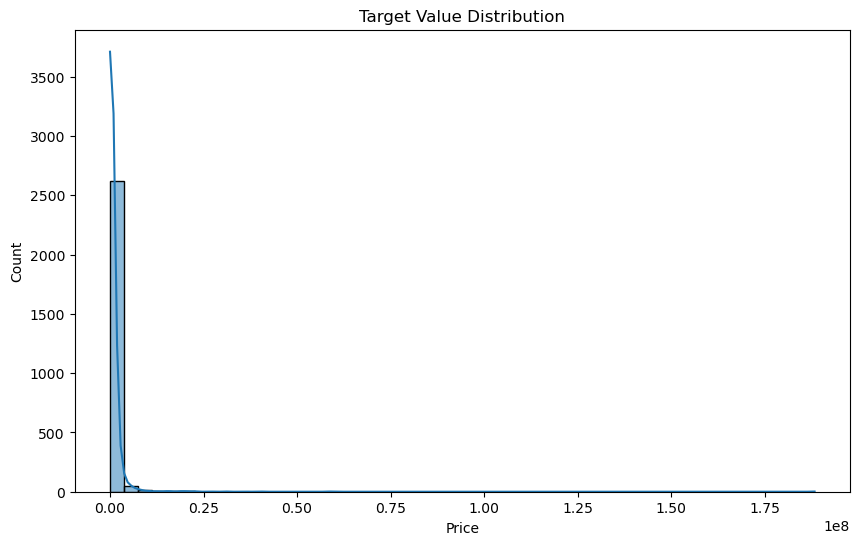

Outliers found: 13.43% of training data


In [33]:
# 1. Check for data leakage
print("Possible leakage indicators:")
print("- Train features in test set:", len(set(X_train.index) & set(X_test.index)))
print("- Constant features:", X_train.columns[X_train.nunique() == 1])
print("- NaN in train:", X_train.isna().sum().sum())
print("- NaN in test:", X_test.isna().sum().sum())

# 2. Verify target distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=50, kde=True)
plt.title('Target Value Distribution')
plt.xlabel('Price')
plt.show()

# 3. Check for outliers
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1
outliers = y_train[(y_train < (Q1 - 1.5 * IQR)) | (y_train > (Q3 + 1.5 * IQR))]
print(f"Outliers found: {len(outliers)/len(y_train):.2%} of training data")